In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
from theano import shared
from sklearn import preprocessing

print('Running on PYMC3 v {}'.format(pm.__version__))

Running on PYMC3 v 3.6


In [2]:
# Read the data
data = pd.read_csv('renfe.csv')
data.head(3)

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo


In [3]:
#Drop the Unnamed column
data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac =0.01,random_state=99)

data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
420104,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
431888,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
791293,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo


In [4]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

As we can see the price column has 12% values which are null. We can fill those by mean of the respective fares

In [5]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

In [6]:
data.isnull().sum()/len(data)

insert_date    0.0
origin         0.0
destination    0.0
start_date     0.0
end_date       0.0
train_type     0.0
price          0.0
train_class    0.0
fare           0.0
dtype: float64

([<matplotlib.axis.YTick at 0x1c1dff4f98>],
 <a list of 1 Text yticklabel objects>)

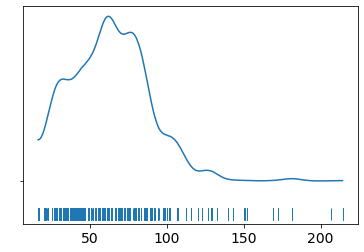

In [7]:
az.plot_kde(data['price'].values, rug= True)
plt.yticks([0], alpha =0)

The KDE plot of price looks like Gaussian-like distribution except for several dozen of data points that are far away from mean

Model Specifications :
    Choices of Prior = 
        μ: mean of the population, Normal Distriibution very wide.set priors reflecting on your knowledge:
            may 0 to 400 for the ticket prices in general
        σ: Standard Deviation of the popultion can only be +ve so use HalfNormal distribution
    Choices for ticket price likelihood funciton:
        y: observed variable representing the data that comes from normal distibution with parameters σ and μ
        

In [8]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 735.85draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1efba320>,
      dtype=object)

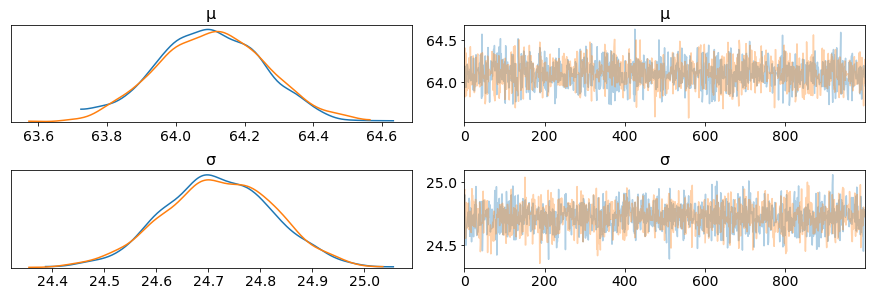

In [9]:
az.plot_trace(trace_g)